# PROTOCOLO DE TELEPORTACION CUANTICA EN LA ESFERA DE BLOCH.

La teleportacion radica en el hecho de trasferir elmente un estado de un unico qubit (bit cuantico) entre dos partes, usualmente llamados Alice y Bob, empleando un par de qubits preparados en estado de Bell (maximamente entrelazados) que comparten las dos partes. En el protocolo reportado por Bennet et. al. Alice posee un estado cuantico  $\ket{\Psi}_{inicial} = \alpha \ket{0}+ \beta \ket{1}$ , donde $\alpha$ $\beta$ y son desconocidos para Alice. Adicionalmente, ella y Bob comparten el estado de Bell dado por,
   
<center>

$\ket{\Psi}_{+} = \frac{1}{\sqrt{2}}(\ket{0}_A\ket{0}_B + \ket{1}_A\ket{1}_B)$

</center>
Donde los subindices A y B indican si el qubit esta localizado en el subsistema de Alice o de Bob.

1) Se representa el estado inicial de Alice $\ket{\Psi}_{inicial}$ en la esfera de Bloch para 3 conjuntos de parametros, teniendo en cuenta que $|\alpha|^2+|\beta|^2=1$ para el estado normalizado.


    1. $\alpha=\sqrt{0.5}, \beta = \sqrt{0.5}$
    2. $\alpha=\sqrt{0.8}, \beta = \sqrt{0.2}$
    3. $\alpha=\sqrt{0.4}, \beta = \sqrt{0.6}$

In [1852]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='dc31b03f027a9bd3feacb5714def6389cd678db34850e8cb6eb42805ecf2539fb88053c8adcf6224cba9c7cb1bca69fb9f0b3e11b2209c774fe42628b743f79f'
)


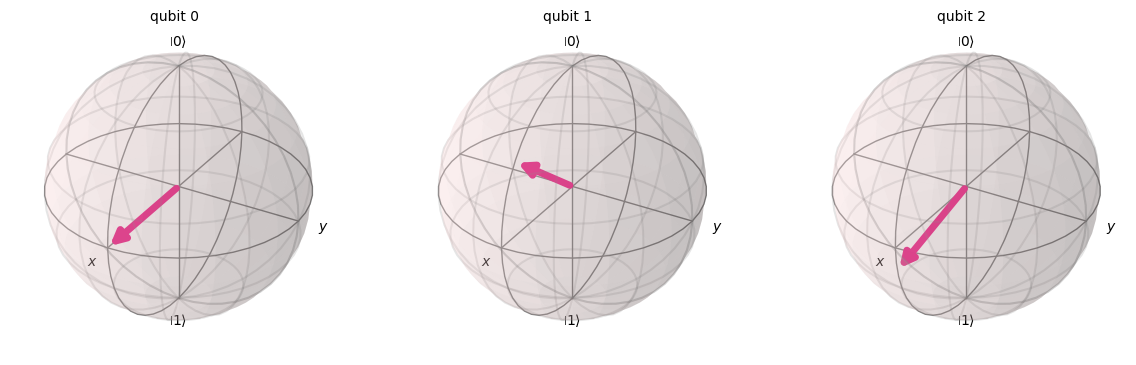

In [1853]:
#Crear un circuito cuántico con 5 qubit
alice_inicial = QuantumCircuit(3)

# Inicializar el qubit en el estado |ψ⟩ = α|0⟩ + β|1⟩

alpha1 = (0.5)**0.5
beta1 = (0.5)**0.5

alpha2 = (0.8)**0.5
beta2 = (0.2)**0.5

alpha3 = (0.4)**0.5
beta3 = (0.6)**0.5


parametros = [[alpha1, beta1], [alpha2, beta2], [alpha3, beta3]]


for i in range(0,3):
    alice_inicial.initialize(parametros[i], i)


# Crear un Statevector solo para los tres primeros qubits
state = Statevector.from_instruction(alice_inicial)

# Dibujar el vector de estado en la esfera de Bloch
plot_bloch_multivector(state)

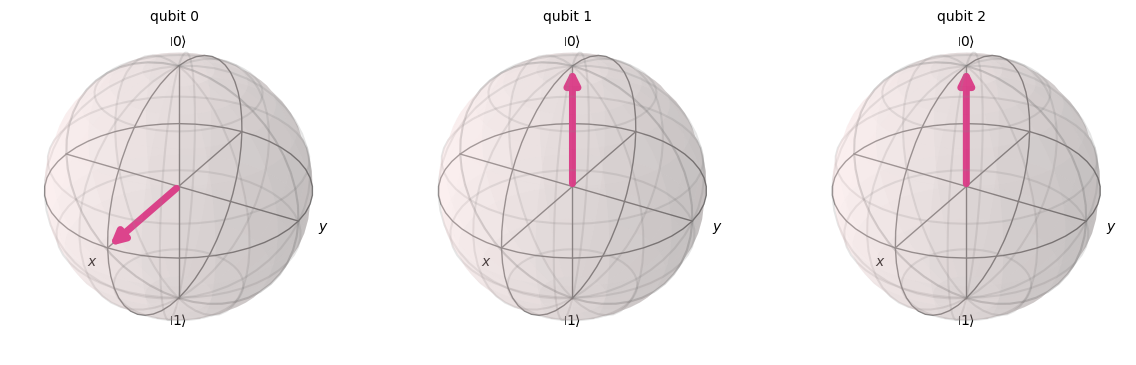

In [1854]:
# Inicializar el qubit en el estado |ψ⟩ = α|0⟩ + β|1⟩

alpha1 = (0.5)**0.5
beta1 = (0.5)**0.5

alpha2 = (0.8)**0.5
beta2 = (0.2)**0.5

alpha3 = (0.4)**0.5
beta3 = (0.6)**0.5

parametros = [[alpha1, beta1], [alpha2, beta2], [alpha3, beta3]]

#Crear los 3 circuitos cuánticos Con 3 qubits y 2 bits clásicos para almacenar los resultados de las mediciones

qreg_names = ['Alice Inicial', 'Alice', 'Bob']
qreg = [[QuantumRegister(1, name=f'{qreg_names[j]}') for j in range(3)] for i in range(3)]
creg = [ClassicalRegister(2, name=f'Mediciones') for i in range(3)]
qc = [QuantumCircuit(*qreg[i], creg[i]) for i in range(3)] 

state = []
for i in range(0,3):
    qc[i].initialize(parametros[i], 0)
    state.append(Statevector(qc[i]))
    
plot_bloch_multivector(state[0])





2. Obtener el estado cuantico compuesto de tres qubits de los subsistemas de Alice y Bob $\ket{\Psi}_{A,B}=\ket{\Psi_{inicial}}\otimes \ket{\Psi_{+}} $

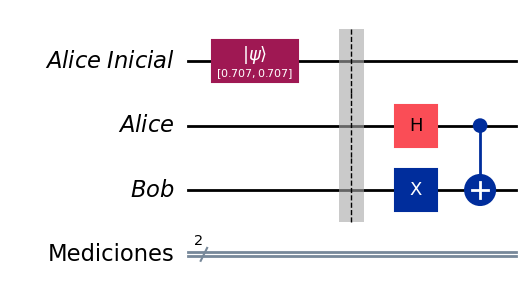

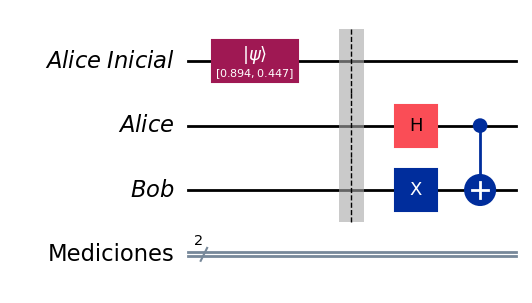

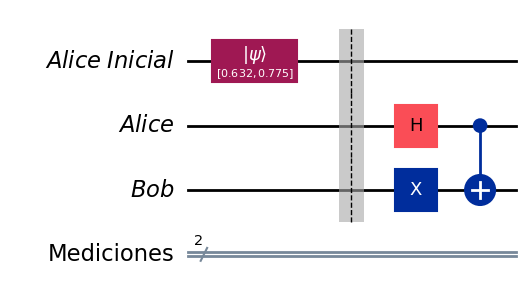

In [1855]:
# Aplicar las puertas necesarias para crear el estado de Bell Psi_+ a cada circuito
for i in range(0,3):
    qc[i].barrier()
    qc[i].x(2)
    qc[i].h(1)
    qc[i].cx(1, 2)

for circuit in qc:
    display(circuit.draw(output='mpl'))

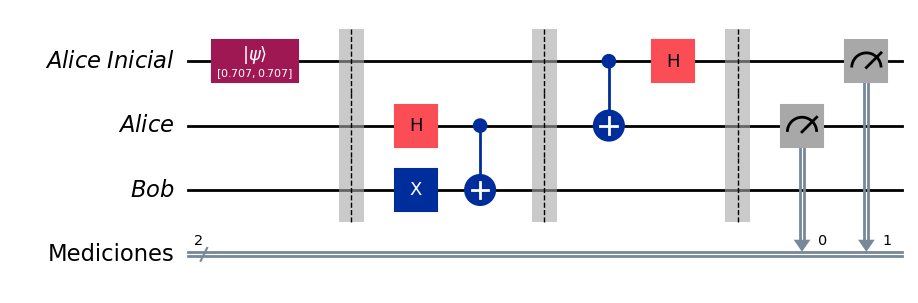

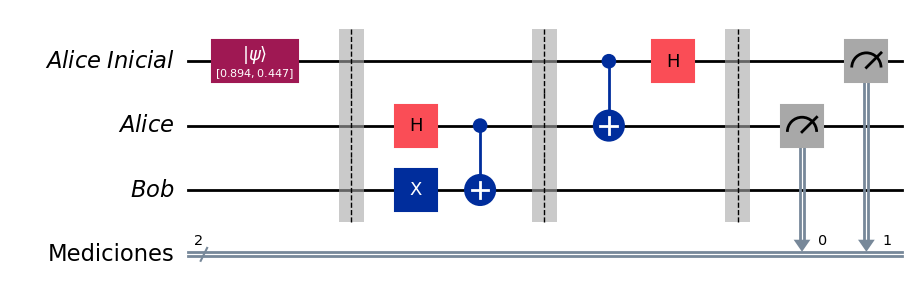

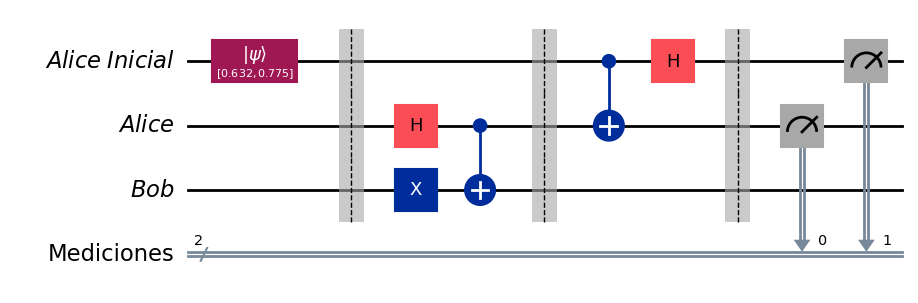

[{'11': 1}, {'00': 1}, {'00': 1}]


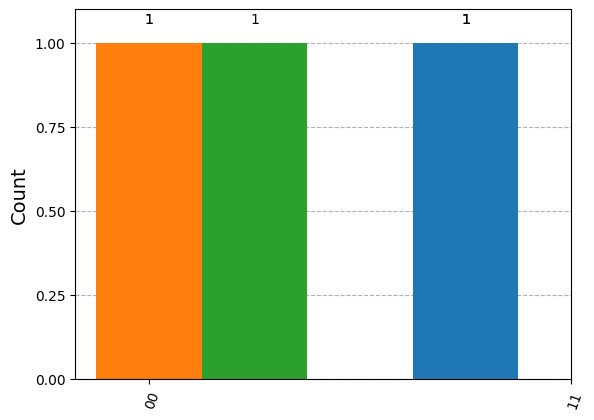

In [1856]:
#Realizar la medición en la base de Bell que corresponde a un CNOT y un Hadamard
for i in range(0,3):
    qc[i].barrier()
    qc[i].cx(0, 1)
    qc[i].h(0)
    qc[i].barrier()
    qc[i].measure([1,0], [0,1])


# Ejecutar el circuito en un simulador y obtener los resultados
simulator1 = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator1)
job = simulator1.run(circ, shots=1)
result = job.result()

for circuit in qc:
    display(circuit.draw(output='mpl'))


# Mostrar los resultados de las mediciones en un histograma

counts = result.get_counts()
print(counts)
plot_histogram(counts)

El resultado de las medición de Alice en el circuito 0 fue: 11


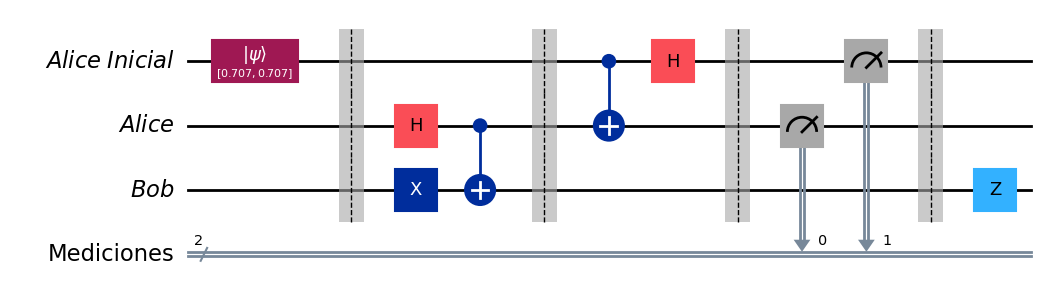

El resultado de las medición de Alice en el circuito 1 fue: 00


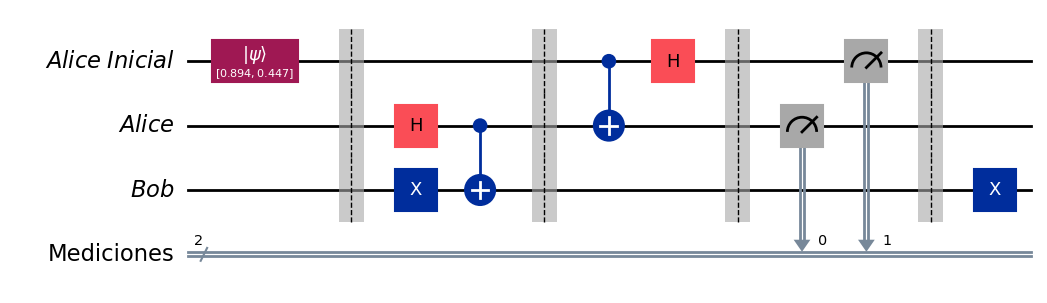

El resultado de las medición de Alice en el circuito 2 fue: 00


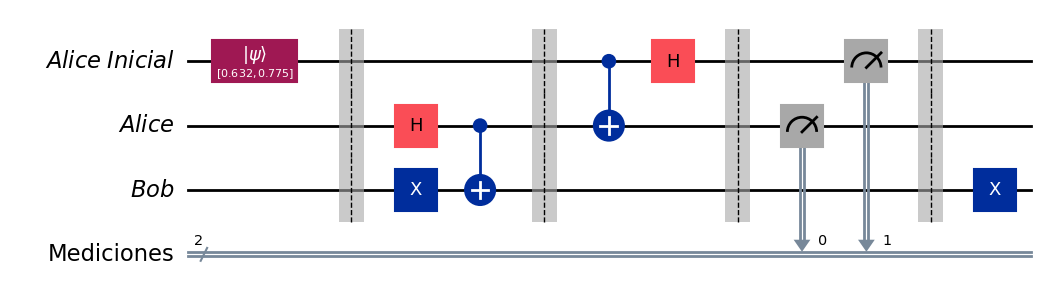

In [1857]:
# Extraer los resultados de las mediciones y guardarlos en una lista
alice = [list(d.keys())[0] for d in counts]

for i in range(0,3):
    qc[i].barrier()
    if alice[i] == '00':
        qc[i].x(2)
    elif alice[i] == '11':
        qc[i].z(2)
    elif alice[i] == '10':
        qc[i].z(2)
        qc[i].x(2)
        
for i, circuit in enumerate(qc):
    print(f'El resultado de las medición de Alice en el circuito {i} fue: {alice[i]}')
    display(circuit.draw(output='mpl'))


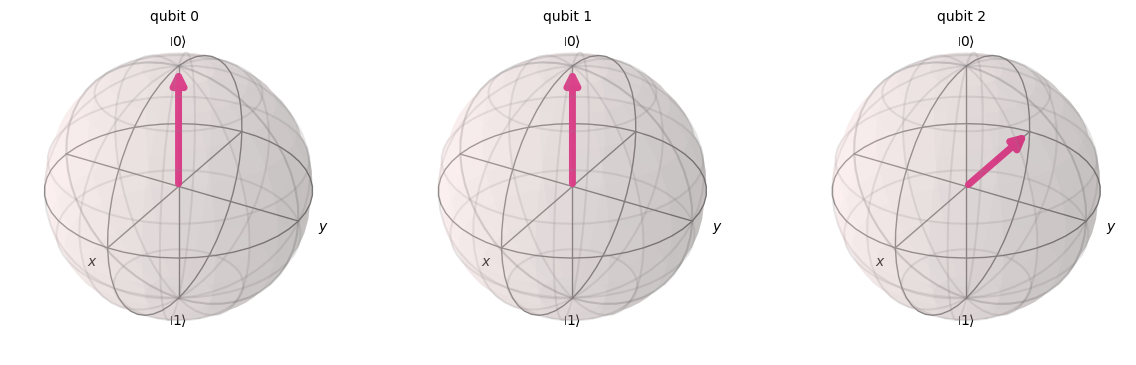

In [1858]:
for i in range(0,3): qc[i].save_statevector()  

# Ejecutar el circuito nuevamente para obtener el estado final después de las operaciones en qubit de Bob
# simulator2 = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator1)
job = simulator1.run(circ, shots=1)
result_final_state = job.result()

statevectors_final_state = [result_final_state.get_statevector(qc[i]) for i in range(0,3)]
plot_bloch_multivector(statevectors_final_state[0])
# # Extraer el estado del qubit de Bob
# bob_states = [partial_trace(statevector, [0, 1]) for statevector in statevectors_final_state]  


# # Graficar el estado final del tercer qubit en la esfera de Bloch
# plot_bloch_multivector(bob_states[0])

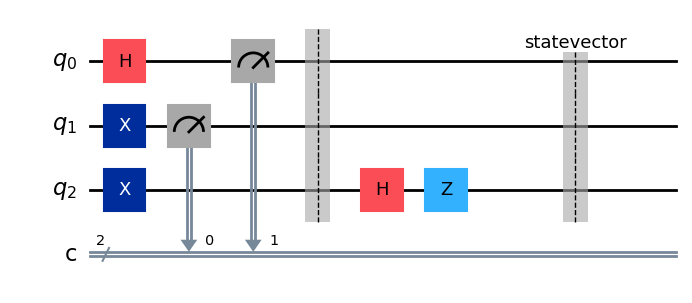

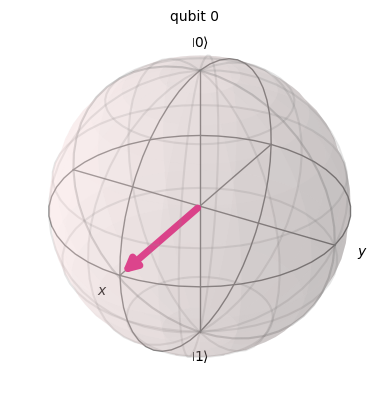

In [1859]:

# Definir el circuito
qc = QuantumCircuit(3, 2)
# Aquí agregas las operaciones a tu circuito
qc.x(1)
qc.h(0)
qc.x(2)
qc.measure([1, 0], [0, 1])  # Medidas antes de operar al tercer qubit

# Ejecutar el circuito en un simulador y obtener los resultados antes de las medidas
# simulator = Aer.get_backend('qasm_simulator')
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1)
result_before_measurement = job.result()

# Aplicar operaciones al tercer qubit
qc.barrier()
qc.h(2)
qc.z(2)
# Ejecutar el circuito nuevamente para obtener el estado final después de las operaciones en el tercer qubit
qc.save_statevector()


circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1)
result_final_state = job.result()
statevector_final_state = result_final_state.get_statevector(qc)
display(qc.draw(output='mpl'))
# Realizar la traza parcial para obtener el estado del tercer qubit después de las operaciones
partial_statevector = partial_trace(statevector_final_state, [0, 1])

# Graficar el estado final del tercer qubit en la esfera de Bloch
plot_bloch_multivector(partial_statevector)


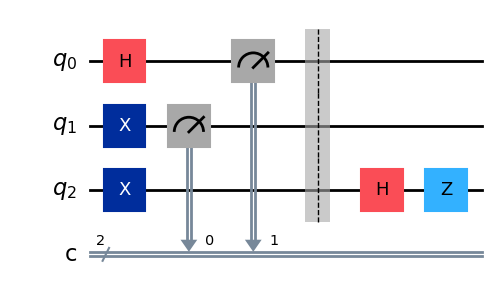

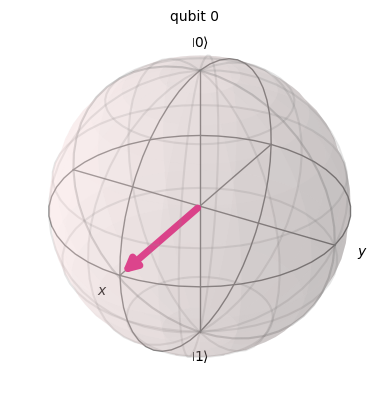

In [1860]:
# Definir el circuito
qc = QuantumCircuit(3, 2)
# Aquí agregas las operaciones a tu circuito
qc.x(1)
qc.h(0)
qc.x(2)
qc.measure([1, 0], [0, 1])  # Medidas antes de operar al tercer qubit

# Ejecutar el circuito en un simulador y obtener los resultados antes de las medidas
simulator = Aer.get_backend('statevector_simulator')
circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1)
result_before_measurement = job.result()
statevector_before_measurement = result_before_measurement.get_statevector(qc)

# Aplicar operaciones al tercer qubit
qc.barrier()
qc.h(2)
qc.z(2)
display(qc.draw(output='mpl'))
# Ejecutar el circuito nuevamente para obtener el estado final después de las operaciones en el tercer qubit
circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1)
result_final_state= job.result()
statevector_final_state = result_final_state.get_statevector(qc)

# Realizar la traza parcial para obtener el estado del tercer qubit después de las operaciones
partial_statevector = partial_trace(statevector_final_state, [0, 1])

# Graficar el estado final del tercer qubit en la esfera de Bloch
plot_bloch_multivector(partial_statevector)

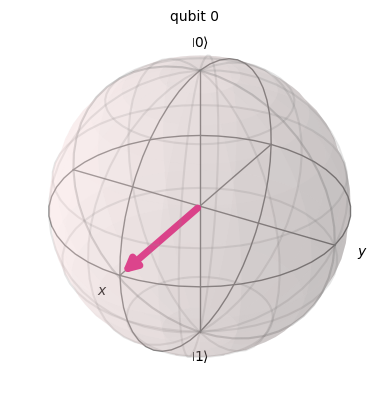

In [1861]:
# Crear los registros cuánticos
qreg = QuantumRegister(1, 'alice')

# Crear el circuito cuántico
qc = QuantumCircuit(qreg)

# Aplicar las puertas X y H
qc.x(0)
qc.h(0)
qc.z(0)
# Obtener el vector de estado
state = Statevector.from_instruction(qc)

# Graficar el estado del qubit en la esfera de Bloch
plot_bloch_multivector(state)